In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy
import pandas as pds
from scipy.optimize import minimize

In [2]:
ge_data = pds.read_csv("SuperCDMS/PhysRevD.99.062001-data/MarchAprilFinal.txt", skiprows=1, \
                         names=['time', 'blah'], \
                         delim_whitespace=False
                     )

ge_data = ge_data.sort_values(by='time')

t = np.asarray(ge_data["time"], dtype=np.float32)


In [3]:
min_t=np.min(t)

#construct histogram from our data, every bin is roughly 12 hours
counts, bins = np.histogram(t-min_t,bins=72)
thing = (bins[:-1]+bins[1:])/2
error1 = [0.00,0.37,0.74,1.10,2.34,2.75,3.82,4.25,5.30,6.33,6.78,7.81,8.83,9.28]
error2 = [1.29,2.75,4.25,5.30,6.78,7.81,9.28,10.30,11.32,12.79,13.81,14.82,16.29,17.30]
ntot_plus = np.zeros(np.shape(counts))
ntot_minus = np.zeros(np.shape(counts))
for i,ncount in enumerate(counts):
    if ncount<=20:
        ntot_plus[i] = error2[ncount]-ncount
        ntot_minus[i] = ncount-error1[ncount]
    else:
        ntot_plus[i] = np.sqrt(ncount)
        ntot_minus[i] = np.sqrt(ncount)

In [4]:
def log_likelihood_func(theta, tstop, nvec): 
    alpha,b=theta
    
    #initialize array of center time for each bin
    times = [] 
    for i in range(len(nvec)):
        result=(tstop/(len(nvec))*nvec[i])
        times.extend([result])
    
    #initialize array of lambdas for each bin according to our model
    lam_array = [] 
    for i in range(len(nvec)):
        result = (np.sum(nvec))*((1/(1+b))*np.exp(-times[i]/alpha)/(alpha*(1-np.exp(-tstop/alpha)))+(b)/tstop)
        lam_array.extend([result])
    
    #Sterling's approximation array
    sterling_array = []
    for i in range(len(nvec)):
        if nvec[i]>12:
                sterling_array.append(nvec[i]*np.log(nvec[i])-nvec[i])
        else:
                sterling_array.append(np.log(np.math.factorial(nvec[i])))
    
    model = 0
    for i in range(len(nvec)):
        model +=(-lam_array[i] + nvec[i]*np.log(lam_array[i])-sterling_array[i])
    return model


In [5]:
alpha = 250
b=1
tstop = 1440

nll = lambda *args: -log_likelihood_func(*args)
initial = np.array([alpha,b])  
soln = scipy.optimize.minimize(nll, initial, args=(tstop, counts), bounds=[(0,1700),(0,9999)]) #add bounds?
alphaml, bml = soln.x
print(soln.x)

'''
nll = lambda args: -log_likelihood_func(args, tstop, counts)
initial = np.array([alpha, b])
soln = scipy.optimize.minimize(nll, initial, bounds=[(0, 9999), (0, 9999)])
alphaml, bml = soln.x'''

[1700.           19.93422463]


'\nnll = lambda args: -log_likelihood_func(args, tstop, counts)\ninitial = np.array([alpha, b])\nsoln = scipy.optimize.minimize(nll, initial, bounds=[(0, 9999), (0, 9999)])\nalphaml, bml = soln.x'

In [6]:
def prior(theta): #this sets the prior conditions of our parameters
    alpha, b = theta
    if alpha>=0 and b>=0 and alpha <=1700:
        return 0.0
    return -np.inf

def prob(theta, tstop, counts):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf 
    result = lp + log_likelihood_func(theta, tstop, counts)
    if np.isnan(np.asarray([result])):
        return -np.inf
    return result

In [7]:
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, prob, args=(tstop, counts)
)

sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\cecih\.conda\envs\neutroncapture\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [08:00<00:00, 20.79it/s]


[43.1010531  31.34713059]
(21120, 2)


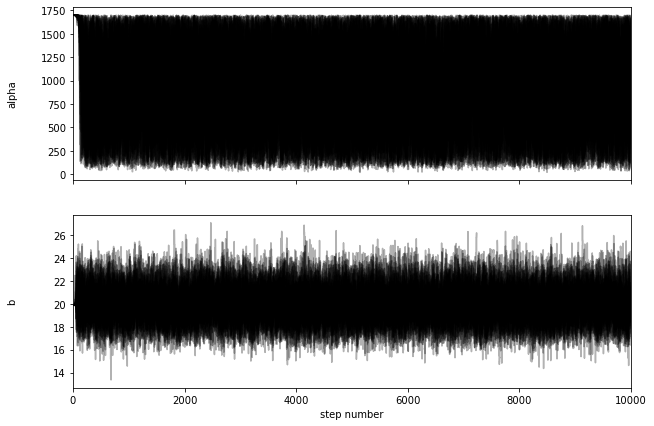

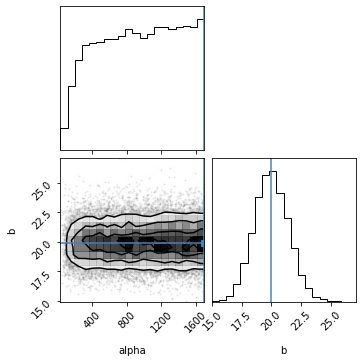

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["alpha","b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[alphaml, bml]
);